In [5]:
import cv2
import numpy as np
import sys

sys.path.append('..')
from opencv_course import ImageUtil

OpenPose的姿势预测模型可以从卡耐基梅隆大学的网站下载，但速度很慢

https://github.com/CMU-Perceptual-Computing-Lab/openpose

- [BODY_25 model](http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/body_25/pose_iter_584000.caffemodel): download in `models/pose/body_25/`.
- [COCO model](http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/coco/pose_iter_440000.caffemodel): download in `models/pose/coco/`.
- [MPI model](http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel): download in `models/pose/mpi/`.
- [Face model](http://posefs1.perception.cs.cmu.edu/OpenPose/models/face/pose_iter_116000.caffemodel): download in `models/face/`.
- [Hands model](http://posefs1.perception.cs.cmu.edu/OpenPose/models/hand/pose_iter_102000.caffemodel): download in `models/hand/`.

也可以在国内百度云下载，链接: https://pan.baidu.com/s/11lbS3HuifeNyly26qI5eng 提取码: g4q6

在运行代码前，先下载不同但模型，如果已经下载，则自动跳过

In [6]:
# COCO model(18 parts)
![ ! -f ../../openpose_model/pose_iter_440000.caffemodel ] && wget http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/coco/pose_iter_440000.caffemodel -o ../../openpose_model/pose_iter_440000.caffemodel
![ ! -f ../../openpose_model/openpose_pose_coco.prototxt ] && wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/openpose_pose_coco.prototxt  -o ../../openpose_model/openpose_pose_coco.prototxt

!rm -f ../../openpose_model/model.caffemodel
!rm -f ../../openpose_model/proto.prototxt
!ln -s ../../openpose_model/pose_iter_440000.caffemodel ../../openpose_model/model.caffemodel 
!ln -s ../../openpose_model/openpose_pose_coco.prototxt ../../openpose_model/proto.prototxt

In [ ]:
# MPI model(16 parts)
![ ! -f ../../openpose_model/pose_iter_160000.caffemodel ] && wget http://osefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel -o ../../openpose_model/pose_iter_160000.caffemodel
![ ! -f ../../openpose_model/openpose_pose_mpi_faster_4_stages.prototxt ] && wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/openpose_pose_mpi_faster_4_stages.prototxt -o ../../openpose_model/openpose_pose_mpi_faster_4_stages.prototxt
    
!rm -f ../../openpose_model/model.caffemodel
!rm -f ../../openpose_model/proto.prototxt
!ln -s ../../openpose_model/pose_iter_160000.caffemodel ../../openpose_model/model.caffemodel 
!ln -s ../../openpose_model/openpose_pose_mpi_faster_4_stages.prototxt ../../openpose_model/proto.prototxt

In [ ]:
# 手势模型
![ ! -f ../../openpose_model/pose_iter_102000.caffemodel ] && wget http://posefs1.perception.cs.cmu.edu/OpenPose/models/hand/pose_iter_102000.caffemodel -o ../../openpose_model/pose_iter_102000.caffemodel
![ ! -f ../../openpose_model/pose_deploy.prototxt ] && wget https://raw.githubusercontent.com/CMU-Perceptual-Computing-Lab/openpose/master/models/hand/pose_deploy.prototxt -o ../../openpose_model/pose_deploy.prototxt

!rm -f ../../openpose_model/model.caffemodel
!rm -f ../../openpose_model/proto.prototxt
!ln -s ../../openpose_model/pose_iter_102000.caffemodel ../../openpose_model/model.caffemodel 
!ln -s ../../openpose_model/pose_deploy.prototxt ../../openpose_model/proto.prototxt

In [25]:
proto = 'proto.prototxt'
model = 'model.caffemodel'

# Specify what kind of model was trained. 
# It could be (COCO, MPI, HAND) depends on dataset.
dataset = 'COCO'

#Threshold value for pose parts heat map
thr = 0.1

#Resize input to specific width.
width = 160

#Resize input to specific height.
height = 160

#Scale for blob
scale= 0.003922

In [9]:
if dataset == 'COCO':
    BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

    POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                   ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]
elif dataset == 'MPI':
    BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                   "Background": 15 }

    POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                   ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                   ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]
else:
    assert(dataset == 'HAND')
    BODY_PARTS = { "Wrist": 0,
                   "ThumbMetacarpal": 1, "ThumbProximal": 2, "ThumbMiddle": 3, "ThumbDistal": 4,
                   "IndexFingerMetacarpal": 5, "IndexFingerProximal": 6, "IndexFingerMiddle": 7, "IndexFingerDistal": 8,
                   "MiddleFingerMetacarpal": 9, "MiddleFingerProximal": 10, "MiddleFingerMiddle": 11, "MiddleFingerDistal": 12,
                   "RingFingerMetacarpal": 13, "RingFingerProximal": 14, "RingFingerMiddle": 15, "RingFingerDistal": 16,
                   "LittleFingerMetacarpal": 17, "LittleFingerProximal": 18, "LittleFingerMiddle": 19, "LittleFingerDistal": 20,
                 }

    POSE_PAIRS = [ ["Wrist", "ThumbMetacarpal"], ["ThumbMetacarpal", "ThumbProximal"],
                   ["ThumbProximal", "ThumbMiddle"], ["ThumbMiddle", "ThumbDistal"],
                   ["Wrist", "IndexFingerMetacarpal"], ["IndexFingerMetacarpal", "IndexFingerProximal"],
                   ["IndexFingerProximal", "IndexFingerMiddle"], ["IndexFingerMiddle", "IndexFingerDistal"],
                   ["Wrist", "MiddleFingerMetacarpal"], ["MiddleFingerMetacarpal", "MiddleFingerProximal"],
                   ["MiddleFingerProximal", "MiddleFingerMiddle"], ["MiddleFingerMiddle", "MiddleFingerDistal"],
                   ["Wrist", "RingFingerMetacarpal"], ["RingFingerMetacarpal", "RingFingerProximal"],
                   ["RingFingerProximal", "RingFingerMiddle"], ["RingFingerMiddle", "RingFingerDistal"],
                   ["Wrist", "LittleFingerMetacarpal"], ["LittleFingerMetacarpal", "LittleFingerProximal"],
                   ["LittleFingerProximal", "LittleFingerMiddle"], ["LittleFingerMiddle", "LittleFingerDistal"] ]

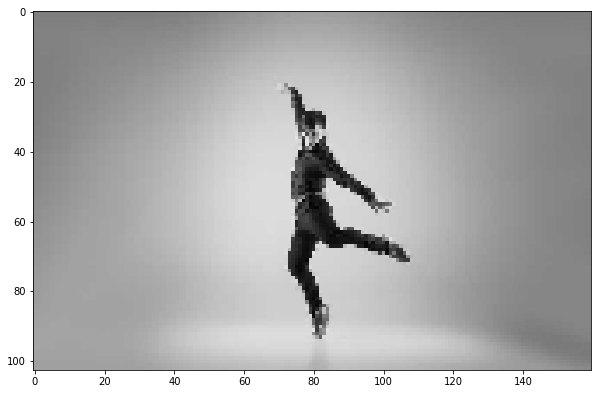

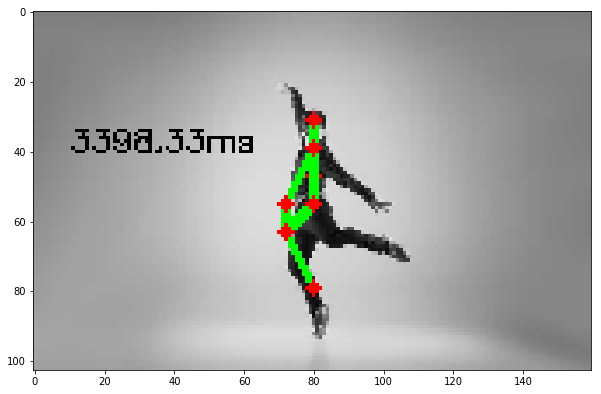

In [31]:
import traitlets
import ipywidgets.widgets as widgets
from IPython.display import display

net = cv2.dnn.readNet(cv2.samples.findFile(proto), cv2.samples.findFile(model))

image = cv2.imread('dance.jpg')

new_width = width
new_height = int(image.shape[0] * width/image.shape[1])
image = cv2.resize(image, (new_width, new_height))

ImageUtil.imshow([image])

inp = cv2.dnn.blobFromImage(image, scale, (new_width, new_height), (0, 0, 0), swapRB=False, crop=False)

#CPU
net.setInput(inp)
out = net.forward()

assert(len(BODY_PARTS) <= out.shape[1])

points = []
for i in range(len(BODY_PARTS)):
    # Slice heatmap of corresponging body's part.
    heatMap = out[0, i, :, :]

    # Originally, we try to find all the local maximums. To simplify a sample
    # we just find a global one. However only a single pose at the same time
    # could be detected this way.
    _, conf, _, point = cv2.minMaxLoc(heatMap)
    x = (new_width * point[0]) / out.shape[3]
    y = (new_height * point[1]) / out.shape[2]

    # Add a point if it's confidence is higher than threshold.
    points.append((int(x), int(y)) if conf > thr else None)

for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    assert(partFrom in BODY_PARTS)
    assert(partTo in BODY_PARTS)

    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]

    if points[idFrom] and points[idTo]:
        cv2.line(image, points[idFrom], points[idTo], (0, 255, 0), 2)
        cv2.ellipse(image, points[idFrom], (2, 2), 0, 0, 360, (0, 0, 255), cv2.FILLED)
        cv2.ellipse(image, points[idTo], (2, 2), 0, 0, 360, (0, 0, 255), cv2.FILLED)

t, _ = net.getPerfProfile()
freq = cv2.getTickFrequency() / 1000
cv2.putText(image, '%.2fms' % (t / freq), (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0))

ImageUtil.imshow([image])